In [1]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import math

Hough transform is an algorithm for automatic detection of lines in an image. It works by representing every straight line (y = kx + n) in an image space as a point (k,n) in a parametric space. The algorithm loops through every pixel and draws all the possible lines that could go through that pixel. In a parametric space we therefore get a line and if these lines from different pixels intersect, we have discovered a linear structure on an image. Since vertical lines cause a problem if written in y = kx + n form, we use Hesse’s normal form where a line equals r = xcos(theta) + ysin(theta).

In [6]:
#functions for calculating gaussian and gaussian derivative
def gauss(sigma):
    x = np.arange( round((-3*sigma)) , round((3*sigma))+1)
    g = ( 1/(math.sqrt(2*math.pi)*sigma) )*math.e**(( -(x)**2 ) / (2*sigma**2))
    g = g/sum(g)
    return g

def gaussdx(sigma):
    x = np.arange( round((-3*sigma)) , round((3*sigma))+1 )
    g = -( 1/(math.sqrt(2*math.pi)*sigma**3) )* x * math.e**(( -(x)**2 ) / (2*sigma**2))
    g = g/sum(abs(g))
    return g

In [7]:
#image derivatives

impulse = np.zeros((25,25))
impulse[12,12]=255
G = np.array([gauss(2)])
D = np.array([gaussdx(2)])
D = np.flip(D)
Gt = np.transpose(G)
Dt = np.transpose(D)

GGt = cv2.filter2D((cv2.filter2D(impulse,-1,G)),-1, Gt)
GDt = cv2.filter2D((cv2.filter2D(impulse,-1,G)),-1, Dt)
GDt = cv2.filter2D((cv2.filter2D(impulse,-1,G)),-1, Dt)
DGt = cv2.filter2D((cv2.filter2D(impulse,-1,D)),-1, Gt)
GtD = cv2.filter2D((cv2.filter2D(impulse,-1,Gt)),-1, D)
DtG = cv2.filter2D((cv2.filter2D(impulse,-1,Dt)),-1, G)


def calculateOdvodi(I, DGt, GDt):
    DGt = np.flip(DGt)
    Ix = cv2.filter2D(I,-1,DGt)
    GDt = np.flip(GDt)
    Iy = cv2.filter2D(I,-1,GDt)

    Ixx = cv2.filter2D((cv2.filter2D(Ix,-1,Gt)),-1, D)
    Iyy = cv2.filter2D((cv2.filter2D(Iy,-1,G)),-1, Dt)
    Ixy = cv2.filter2D((cv2.filter2D(Ix,-1,G)),-1, Dt)

    mag = cv2.sqrt(Ix**2 + Iy**2)
    mag = mag.astype("float32")
    phi = np.arctan2(Iy,Ix)

    return Ix,Iy,Ixx,Iyy,Ixy,phi,mag

In [8]:
def findEdges(mag,sigma,theta):
    Ie = np.zeros((mag.shape[0],mag.shape[1]))
    Ie[mag >= theta] = 1
    Ie[mag < theta] = 0
    return Ie

In [9]:
def draw_line(rho, theta, max_rho):
	a = np.cos(theta)
	b = np.sin(theta)

	x0 = a*rho
	y0 = b*rho

	x1 = int(x0 + max_rho*(-b))
	y1 = int(y0 + max_rho*(a))
	x2 = int(x0 - max_rho*(-b))
	y2 = int(y0 - max_rho*(a))
    
	plt.plot((y1,y2),(x1,x2),'r')

In [10]:
def nonmaxima_suppression_box(accum):
    for i in np.arange(1, accum.shape[0]-1):
        for j in np.arange(1,accum.shape[1]-1):
            sosedi = accum[ (i-1):(i+2) , (j-1):(j+2) ]
            if (np.any(sosedi > accum[i][j] )):
                accum[i][j] = 0
    return accum

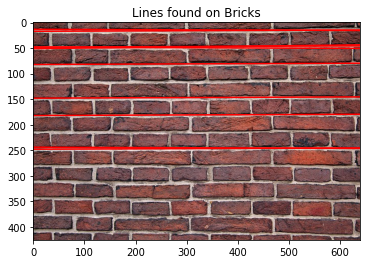

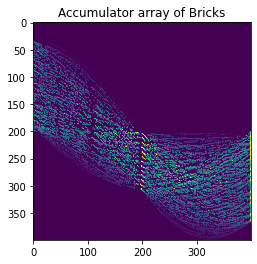

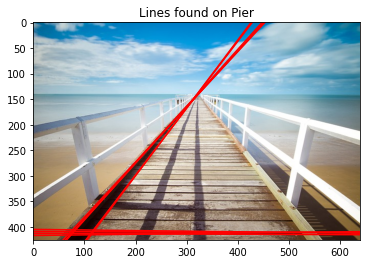

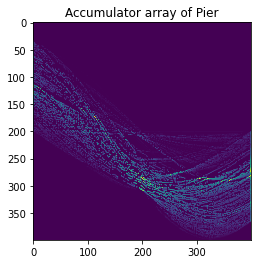

In [23]:
def hough_find_and_draw_top10_lines(I, rho, theta, threshold):
    binsTheta = theta
    binsRho = rho
    maxRho = math.sqrt((I.shape[0]-1)**2 + (I.shape[1]-1)**2)
    accum = np.zeros((binsRho,binsTheta))
    valTheta = (np.linspace(-90,90, binsTheta) / 180) * math.pi
    valRho = np.linspace(-maxRho,maxRho,binsRho)

    x = I.nonzero()[0]
    y = I.nonzero()[1]

    for m in np.arange(0,y.shape[0]):
        rho = (x[m] * np.cos(valTheta)) + (y[m] * np.sin(valTheta))
        binRho = np.floor( ( (rho + maxRho) / (2*maxRho)) * valRho.shape[0] )
        
        for i in np.arange(0,binsTheta):
            if binRho[i] >= 0 and (binRho[i] < binsRho):
            	accum[ int(binRho[i]),i] += 1

    indicesThr = np.argwhere((accum > threshold))
    listMostVoted = np.zeros((indicesThr.shape[0],3))
    
    for i in np.arange(0, indicesThr.shape[0]):

        listMostVoted[i][0] = accum[ indicesThr[i][0] ,  indicesThr[i][1]  ]
        listMostVoted[i][1] = indicesThr[i][0]
        listMostVoted[i][2] = indicesThr[i][1]

    sorted_array = listMostVoted[np.argsort(listMostVoted[:, 0])]

    for j in range((sorted_array.shape[0]-1), (sorted_array.shape[0]-11), -1):

        biny = int(sorted_array[j][1])
        binx = int(sorted_array[j][2])
        realTheta = valTheta[binx]
        realRho = valRho[biny]
        draw_line( realRho, realTheta, maxRho)
    return accum

#preberi slike
bricks = cv2.imread('images/bricks.jpg')
bricks = cv2.cvtColor(bricks, cv2.COLOR_RGB2BGR)
bricks = cv2.cvtColor(bricks, cv2.COLOR_RGB2GRAY)
bricks = bricks.astype("float32")
pier = cv2.imread('images/pier.jpg')
pier = cv2.cvtColor(pier, cv2.COLOR_RGB2BGR)
pier = cv2.cvtColor(pier, cv2.COLOR_RGB2GRAY)
pier = pier.astype("float32")

#izracunaj odvode, edges, hough transform in non maxima suppresion akumulacijske matrike
_,_,_,_,_,phibricks,magbricks = calculateOdvodi(bricks,DGt,GDt)
Iebricks = findEdges(magbricks,0,8000)
accumbricks = hough_find_and_draw_top10_lines(Iebricks, 400, 400, 700)
sBricks = nonmaxima_suppression_box(accumbricks)
bricks = cv2.imread('images/bricks.jpg')
bricks = cv2.cvtColor(bricks, cv2.COLOR_RGB2BGR)
plt.imshow(bricks)
plt.title("Lines found on Bricks")
plt.show()
plt.imshow(sBricks,vmax=255)
plt.title("Accumulator array of Bricks")
plt.show()

#izracunaj odvode, edges, hough transform in non maxima suppresion akumulacijske matrike
_,_,_,_,_,phipier,magpier = calculateOdvodi(pier,DGt,GDt)
Iepier= findEdges(magpier,0,6500)
accumpier = hough_find_and_draw_top10_lines(Iepier, 400, 400, 700)
spier = nonmaxima_suppression_box(accumpier)
pier = cv2.imread('images/pier.jpg')
pier = cv2.cvtColor(pier, cv2.COLOR_RGB2BGR)
plt.imshow(pier)
plt.title("Lines found on Pier")
plt.show()
plt.imshow(spier,vmax=255)
plt.title("Accumulator array of Pier")
plt.show()